# Mac Address Feature Cleaning

The notebook aims at understanding the mac addresses using a clustering algorithm (k-means) to determine whether the mac addresses are stationary or moving (shoppers).

In [2]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import scale

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
matplotlib.style.use('ggplot')

In [3]:
%load_ext autoreload
%autoreload 2

## Import the data and create mac address data frame

In [4]:
mac_address_df = pd.read_csv('../data/mac_address_features.csv')

In [5]:
print('{} mac addresses'.format(len(mac_address_df)))

154152 mac addresses


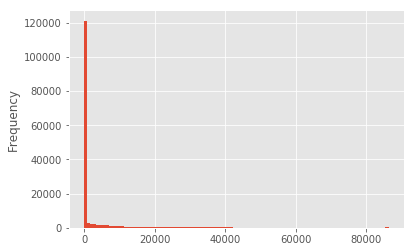

In [21]:
mac_address_df['length_of_stay'].plot.hist(bins=100)

In [6]:
mac_address_df.head()

,count,mac_address,manufacturer,gyration,cdv,length_of_stay,is_out_of_hours,turning_circle
0,6606,bc:20:10:8c:fe:05,NaN,10.848379,50.790938,86335,1,1.969722
1,5718,98:fc:11:eb:90:65,"Cisco-Linksys, LLC",20.430586,26.874078,86335,1,2.344452
2,5686,c4:f0:81:19:be:fc,"HUAWEI TECHNOLOGIES CO.,LTD",8.211081,45.712970,86284,1,2.015278
3,5332,e8:de:27:5e:bf:99,"TP-LINK TECHNOLOGIES CO.,LTD.",47.177085,24.980181,86089,1,1.370981
4,5281,9c:99:a0:07:5e:a9,Xiaomi Communications Co Ltd,9.771733,48.059259,86335,1,2.053495


## Correlation Analysis

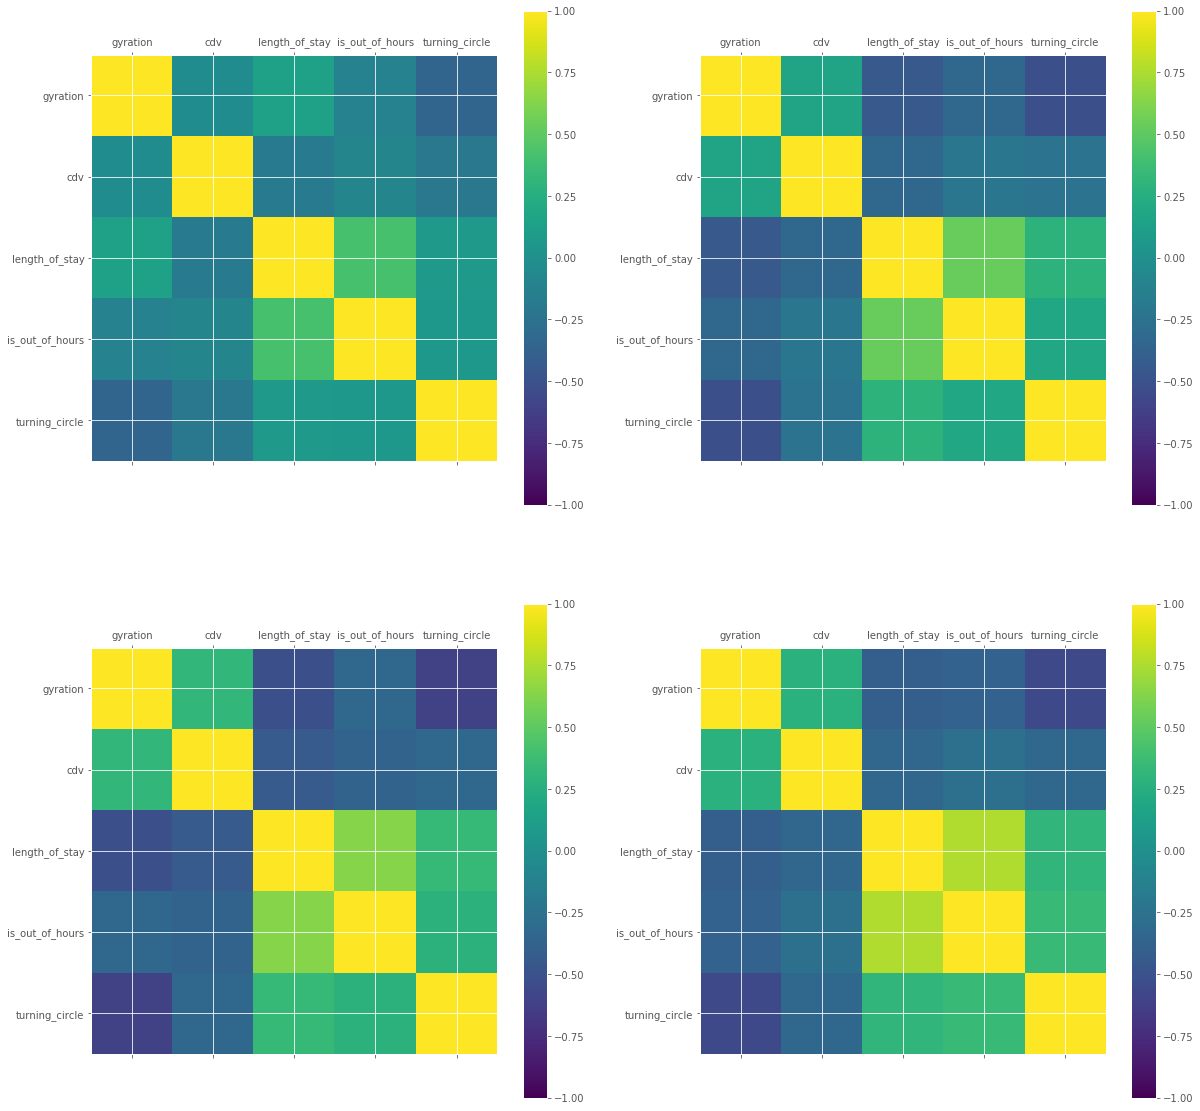

In [7]:
names = ['gyration', 'cdv', 'length_of_stay', 'is_out_of_hours', 'turning_circle']

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

correlations0 = mac_address_df[(mac_address_df['count'] > 10) & (mac_address_df['count'] < 100)][names].corr()
cax = ax0.matshow(correlations0, vmin=-1, vmax=1)
ticks = np.arange(0,len(names),1)
ax0.set_xticks(ticks)
ax0.set_yticks(ticks)
ax0.set_xticklabels(names)
ax0.set_yticklabels(names)
fig.colorbar(cax, ax=ax0);

correlations1 = mac_address_df[(mac_address_df['count'] > 100) & (mac_address_df['count'] < 250)][names].corr()
cax = ax1.matshow(correlations1, vmin=-1, vmax=1)
ticks = np.arange(0,len(names),1)
ax1.set_xticks(ticks)
ax1.set_yticks(ticks)
ax1.set_xticklabels(names)
ax1.set_yticklabels(names)
fig.colorbar(cax, ax=ax1);

correlations2 = mac_address_df[(mac_address_df['count'] > 250) & (mac_address_df['count'] < 500)][names].corr()
cax = ax2.matshow(correlations2, vmin=-1, vmax=1)
ticks = np.arange(0,len(names),1)
ax2.set_xticks(ticks)
ax2.set_yticks(ticks)
ax2.set_xticklabels(names)
ax2.set_yticklabels(names)
fig.colorbar(cax, ax=ax2);

correlations3 = mac_address_df[(mac_address_df['count'] > 500) & (mac_address_df['count'] < 1000)][names].corr()
cax = ax3.matshow(correlations3, vmin=-1, vmax=1)
ticks = np.arange(0,len(names),1)
ax3.set_xticks(ticks)
ax3.set_yticks(ticks)
ax3.set_xticklabels(names)
ax3.set_yticklabels(names)
fig.colorbar(cax, ax=ax3);

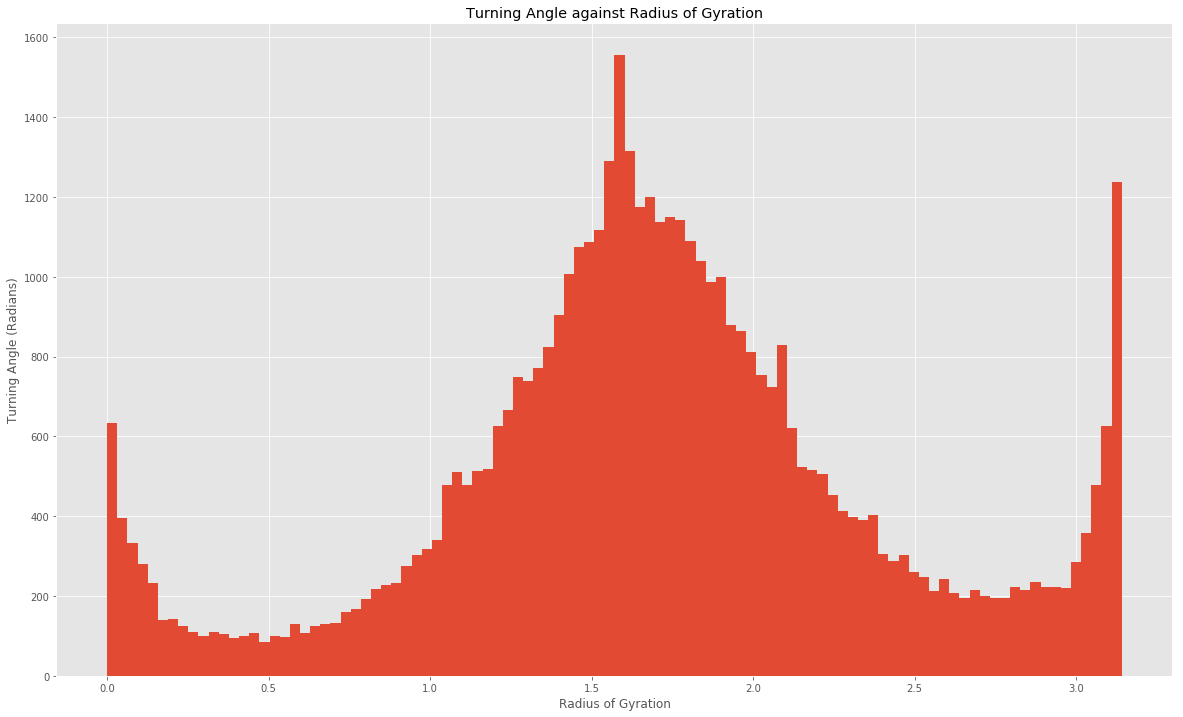

In [9]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20, 12))

mac_count_range_df = mac_address_df[(mac_address_df['count'] > 500) & (mac_address_df['count'] < 1000)]
mac_address_df.turning_circle.plot.hist(bins=100, ax=ax1)
ax1.set_title('Turning Angle against Radius of Gyration')
ax1.set_xlabel('Radius of Gyration')
ax1.set_ylabel('Turning Angle (Radians)');

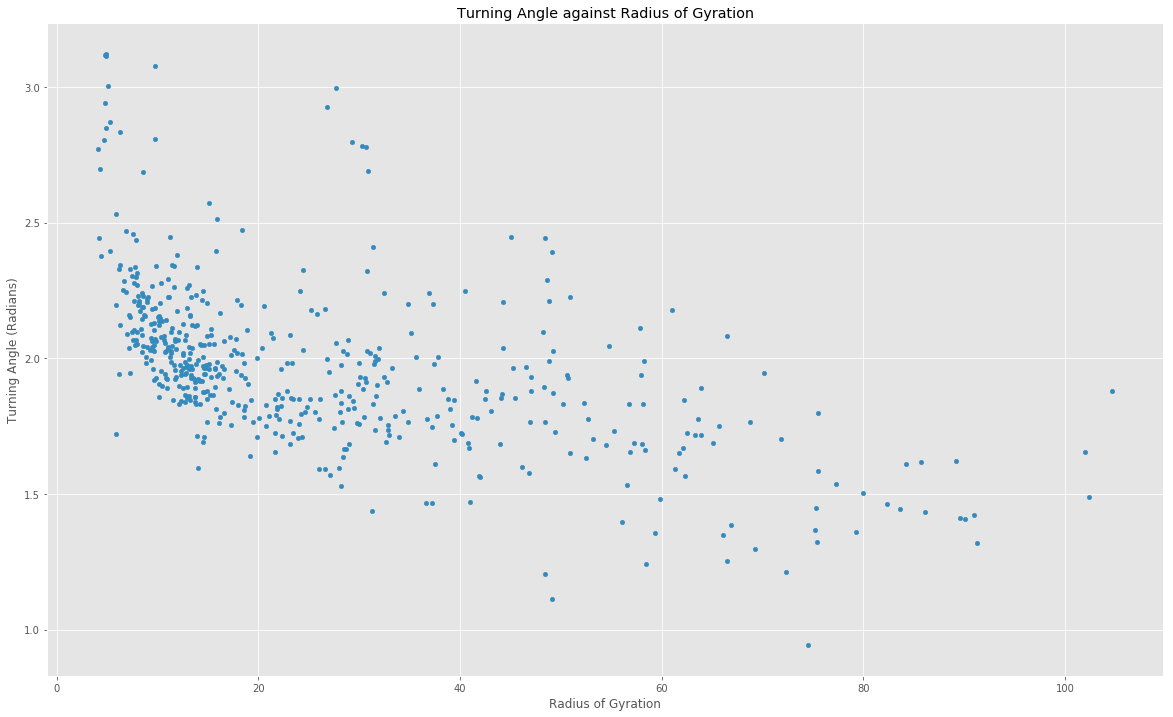

In [15]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20, 12))

mac_count_range_df = mac_address_df[(mac_address_df['count'] > 500) & (mac_address_df['count'] < 1000)]
mac_count_range_df.plot.scatter('gyration', 'turning_circle', ax=ax1)
ax1.set_title('Turning Angle against Radius of Gyration')
ax1.set_xlabel('Radius of Gyration')
ax1.set_ylabel('Turning Angle (Radians)');

## Cluster Analysis

In [243]:
mac_address_clean_df = mac_address_df.dropna()

In [244]:
mac_address_clean_df = mac_address_clean_df[(mac_address_clean_df['count'] > 100) & (mac_address_clean_df['count'] < 250)]

In [245]:
mac_address_clean_df.describe()

,count,gyration,cdv,length_of_stay,is_out_of_hours
count,3868.000000,3868.000000,3868.000000,3868.000000,3868.000000
mean,151.077042,66.575556,8.240744,18797.614271,0.024302
std,39.087752,25.187564,3.979449,18385.603002,0.154005
min,101.000000,0.000000,0.790569,1554.000000,0.000000
25%,118.000000,53.662724,5.557125,7532.000000,0.000000
50%,142.000000,70.160937,7.672761,11486.000000,0.000000
75%,176.000000,83.514055,10.130857,22060.500000,0.000000
max,249.000000,133.721172,32.057240,86294.000000,1.000000


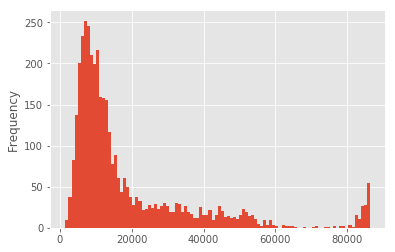

In [246]:
mac_address_clean_df['length_of_stay'].plot.hist(bins=100)

In [200]:
30000/60/60

8.333333333333334

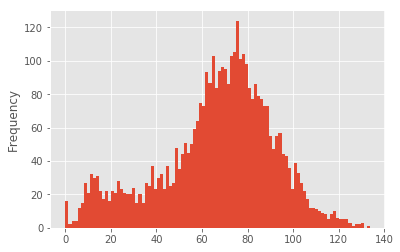

In [247]:
mac_address_clean_df['gyration'].plot.hist(bins=100)

In [218]:
mac_address_clean_df['gyration'] = scale(mac_address_clean_df['gyration'])
mac_address_clean_df['count'] = scale(mac_address_clean_df['count'])
mac_address_clean_df['length_of_stay'] = scale(mac_address_clean_df['length_of_stay'])
# mac_address_clean_df['is_out_of_hours'][mac_address_clean_df['is_out_of_hours'] == 0] = -1
# mac_address_clean_df['is_out_of_hours'] = mac_address_clean_df['is_out_of_hours'] * 2

c:\users\tvb\envs\venv-msci\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [219]:
samples = mac_address_clean_df.as_matrix(columns=['gyration', 'count', 'length_of_stay', 'is_out_of_hours'])

In [88]:
samples = scale(samples)

In [223]:
n_clusters = 4

model = KMeans(n_clusters=n_clusters)
model.fit(samples)
labels = model.predict(samples)

In [220]:
for n_clusters in range(2, 10):

    model = KMeans(n_clusters=n_clusters)
    model.fit(samples)
    labels = model.predict(samples)

    silhouette_avg = silhouette_score(samples, labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.439483932475
For n_clusters = 3 The average silhouette_score is : 0.343485274206
For n_clusters = 4 The average silhouette_score is : 0.322733852342
For n_clusters = 5 The average silhouette_score is : 0.336596786015
For n_clusters = 6 The average silhouette_score is : 0.309759106703
For n_clusters = 7 The average silhouette_score is : 0.288825184421
For n_clusters = 8 The average silhouette_score is : 0.286246858542
For n_clusters = 9 The average silhouette_score is : 0.286725907188


In [99]:
mac_address_clean_df['cluster'] = labels

c:\users\tvb\envs\venv-msci2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


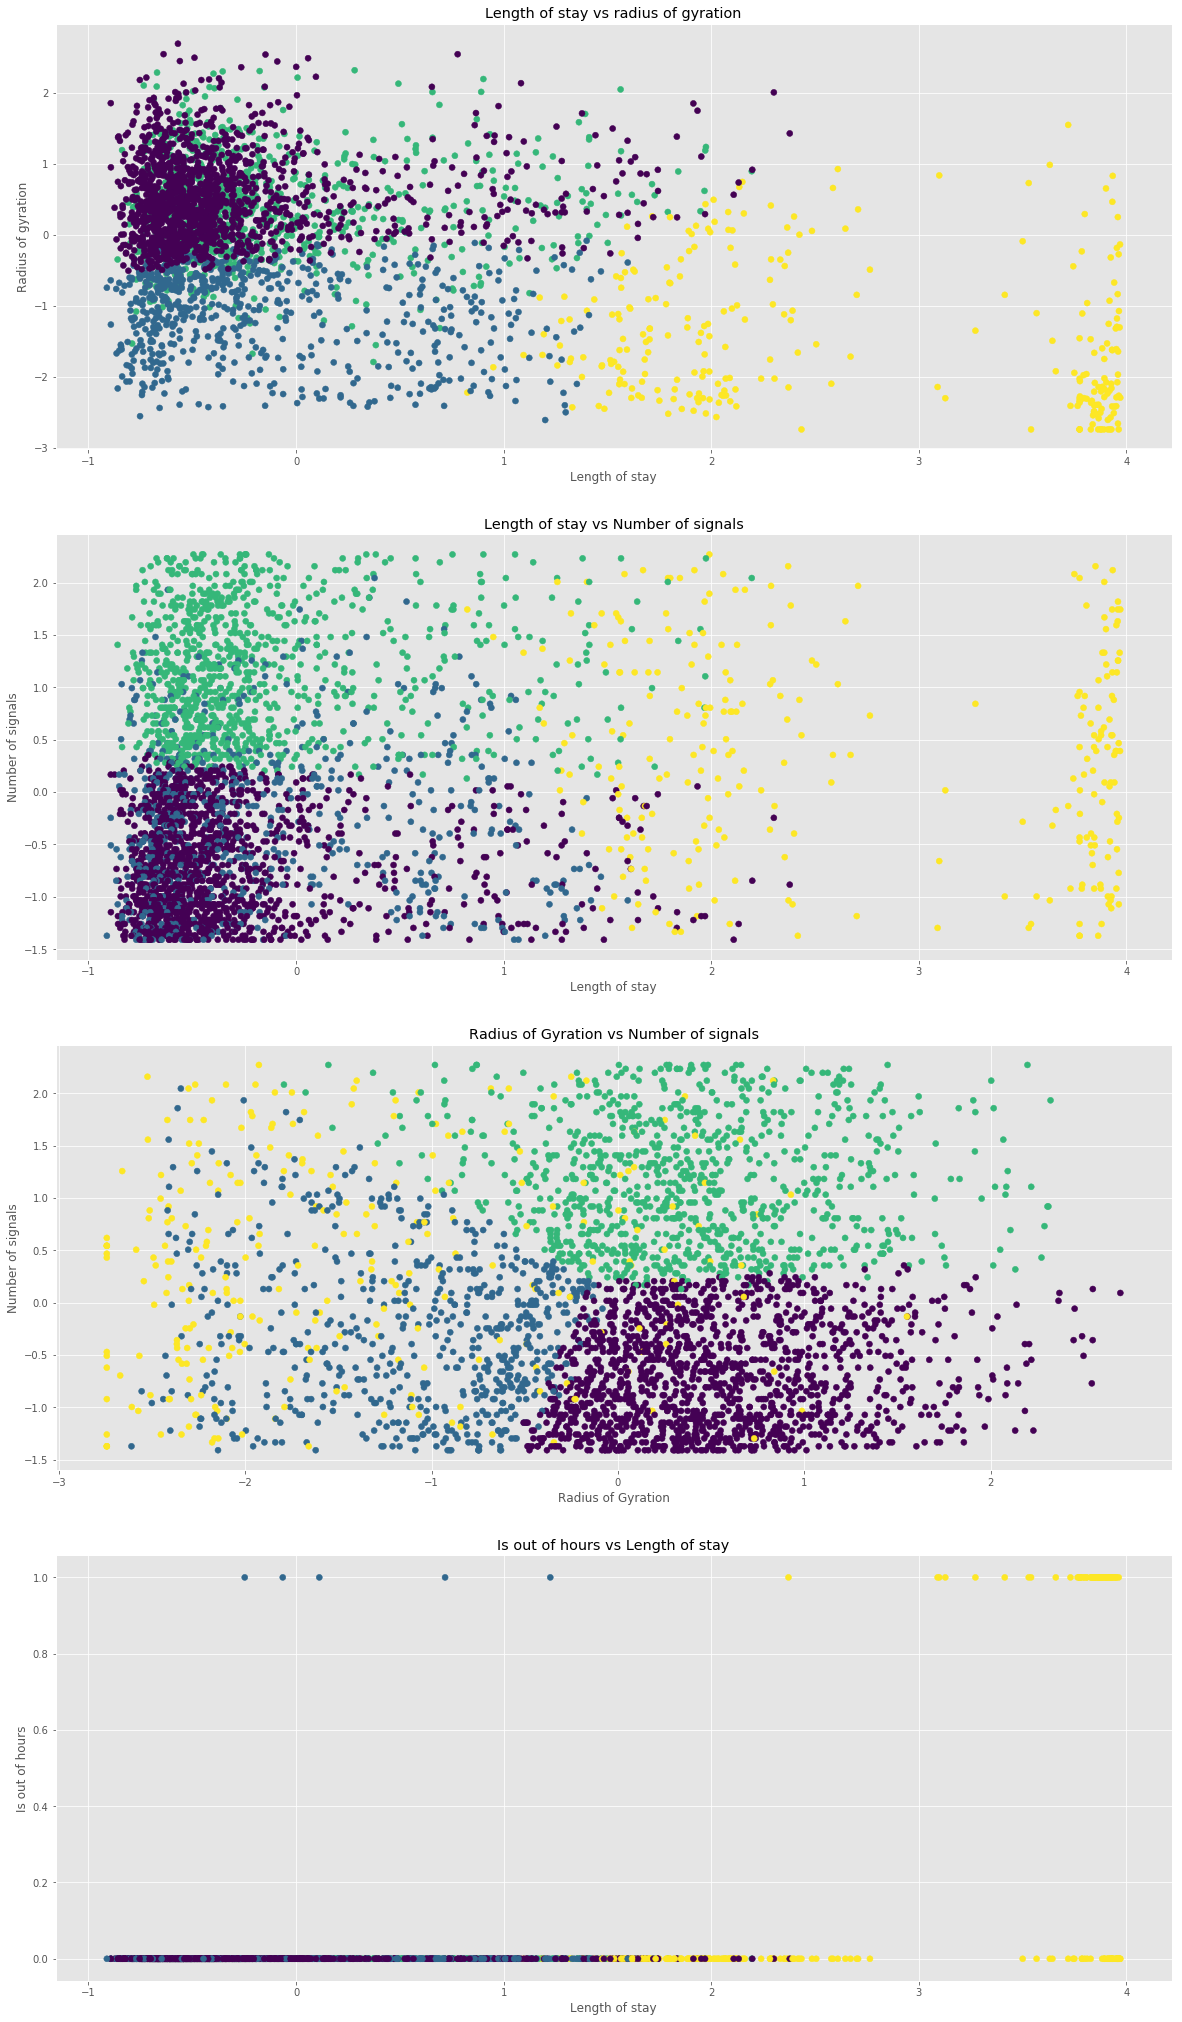

In [224]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 36))

xs = samples[:,2]
ys = samples[:,0]

axes[0].scatter(xs, ys, c=labels)
axes[0].set_title('Length of stay vs radius of gyration')
axes[0].set_xlabel('Length of stay')
axes[0].set_ylabel('Radius of gyration');

xs = samples[:,2]
ys = samples[:,1]

axes[1].scatter(xs, ys, c=labels)
axes[1].set_title('Length of stay vs Number of signals')
axes[1].set_xlabel('Length of stay')
axes[1].set_ylabel('Number of signals');

xs = samples[:,0]
ys = samples[:,1]

axes[2].scatter(xs, ys, c=labels)
axes[2].set_title('Radius of Gyration vs Number of signals')
axes[2].set_xlabel('Radius of Gyration')
axes[2].set_ylabel('Number of signals');

xs = samples[:,2]
ys = samples[:,3]

axes[3].scatter(xs, ys, c=labels)
axes[3].set_title('Is out of hours vs Length of stay')
axes[3].set_xlabel('Length of stay')
axes[3].set_ylabel('Is out of hours');

In [31]:
mac_address_clean_df.cluster.value_counts()

AttributeError: 'DataFrame' object has no attribute 'cluster'